In [1]:
import os

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import librosa, librosa.display
import soundfile

from tqdm.notebook import tqdm

from vq_vae_2_half_tmb import Model
from transformer import VQVAETransformer

In [3]:
seed = 100

In [4]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
#device = torch.device('cpu')

In [6]:
SAVE_PATH = "./save_models"

In [7]:
num_hiddens = 128 #128
num_residual_hiddens = 32
num_residual_layers = 4
embedding_dim = 64 #64
num_embeddings = 512 #512
commitment_cost = 0.25

In [8]:
vqvae = Model(num_hiddens=num_hiddens, 
                  num_residual_layers=num_residual_layers,
                  num_residual_hiddens=num_residual_hiddens,
                  num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim, 
                  commitment_cost=commitment_cost).to(device)

score = 79.73939
MODEL_PATH = f'{SAVE_PATH}/vqvae2_tmb-{score:.5f}_dict.pt'
vqvae.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [9]:
#top_sample = torch.randint(1, 513, [1, 10, 32]).to(device)
#print(512 in top_sample)
#with torch.no_grad():
#    quant_t = vqvae.vq_top.embed_code(top_sample - 1)
#    quant_t = quant_t.permute(0, 3, 1, 2).contiguous()

In [10]:
torch.cuda.empty_cache()

In [11]:
#import importlib
#import transformer
#importlib.reload(transformer)
#from transformer import VQVAETransformer

In [12]:
import argparse
parser = argparse.ArgumentParser(description="VQGAN")
parser.add_argument('--run-name', type=str, default=None)
parser.add_argument('--latent-dim', type=int, default=32, help='Latent dimension n_z.')
parser.add_argument('--image-size', type=int, default=256, help='Image height and width.)')
parser.add_argument('--num-codebook-vectors', type=int, default=8192, help='Number of codebook vectors.')
parser.add_argument('--beta', type=float, default=0.25, help='Commitment loss scalar.')
parser.add_argument('--image-channels', type=int, default=3, help='Number of channels of images.')
parser.add_argument('--dataset-path', type=str, default='./data', help='Path to data.')
parser.add_argument('--checkpoint-path', type=str, default='./checkpoints/last_ckpt.pt', help='Path to checkpoint.')
parser.add_argument('--device', type=str, default="cuda", help='Which device the training is on.')
parser.add_argument('--batch-size', type=int, default=10, help='Batch size for training.')
parser.add_argument('--accum-grad', type=int, default=10, help='Number for gradient accumulation.')
parser.add_argument('--epochs', type=int, default=300, help='Number of epochs to train.')
parser.add_argument('--start-from-epoch', type=int, default=1, help='Number of epochs to train.')
parser.add_argument('--ckpt-interval', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--learning-rate', type=float, default=1e-4, help='Learning rate.')

parser.add_argument('--sos-token', type=int, default=1025, help='Start of Sentence token.')

parser.add_argument('--n-layers', type=int, default=24, help='Number of layers of transformer.')
parser.add_argument('--dim', type=int, default=768, help='Dimension of transformer.')
parser.add_argument('--hidden-dim', type=int, default=3072, help='Dimension of transformer.')
parser.add_argument('--num-image-tokens', type=int, default=256, help='Number of image tokens.')

args = parser.parse_args(args=[])
args.run_name = "<name>"
args.dataset_path = r"C:\Users\dome\datasets\landscape"
args.checkpoint_path = r".\checkpoints"
args.n_layers = 24
args.dim = 512
args.hidden_dim = 3072
args.batch_size = 4
args.accum_grad = 25
args.epochs = 1000

args.start_from_epoch = 0

args.num_codebook_vectors = 511
args.num_image_tokens = 10 * 32 # 20 * 64 # 40 * 128

model_top = VQVAETransformer(args).to(device)

Initializing Module Embedding.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Mod

In [13]:
model_top.load_state_dict(torch.load(f"./checkpoints/transformer_current_top.pt"))

<All keys matched successfully>

In [14]:
import argparse
parser = argparse.ArgumentParser(description="VQGAN")
parser.add_argument('--run-name', type=str, default=None)
parser.add_argument('--latent-dim', type=int, default=32, help='Latent dimension n_z.')
parser.add_argument('--image-size', type=int, default=256, help='Image height and width.)')
parser.add_argument('--num-codebook-vectors', type=int, default=8192, help='Number of codebook vectors.')
parser.add_argument('--beta', type=float, default=0.25, help='Commitment loss scalar.')
parser.add_argument('--image-channels', type=int, default=3, help='Number of channels of images.')
parser.add_argument('--dataset-path', type=str, default='./data', help='Path to data.')
parser.add_argument('--checkpoint-path', type=str, default='./checkpoints/last_ckpt.pt', help='Path to checkpoint.')
parser.add_argument('--device', type=str, default="cuda", help='Which device the training is on.')
parser.add_argument('--batch-size', type=int, default=10, help='Batch size for training.')
parser.add_argument('--accum-grad', type=int, default=10, help='Number for gradient accumulation.')
parser.add_argument('--epochs', type=int, default=300, help='Number of epochs to train.')
parser.add_argument('--start-from-epoch', type=int, default=1, help='Number of epochs to train.')
parser.add_argument('--ckpt-interval', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--learning-rate', type=float, default=1e-4, help='Learning rate.')

parser.add_argument('--sos-token', type=int, default=1025, help='Start of Sentence token.')

parser.add_argument('--n-layers', type=int, default=24, help='Number of layers of transformer.')
parser.add_argument('--dim', type=int, default=768, help='Dimension of transformer.')
parser.add_argument('--hidden-dim', type=int, default=3072, help='Dimension of transformer.')
parser.add_argument('--num-image-tokens', type=int, default=256, help='Number of image tokens.')

args = parser.parse_args(args=[])
args.run_name = "<name>"
args.dataset_path = r"C:\Users\dome\datasets\landscape"
args.checkpoint_path = r".\checkpoints"
args.n_layers = 24
args.dim = 512
args.hidden_dim = 3072
args.batch_size = 4
args.accum_grad = 25
args.epochs = 200

args.start_from_epoch = 0

args.num_codebook_vectors = 511
args.num_image_tokens = 20 * 64

model_mid = VQVAETransformer(args).to(device)

Initializing Module Embedding.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Mod

In [15]:
model_mid.load_state_dict(torch.load(f"./checkpoints/transformer_current_mid.pt"))

<All keys matched successfully>

In [16]:
import argparse
parser = argparse.ArgumentParser(description="VQGAN")
parser.add_argument('--run-name', type=str, default=None)
parser.add_argument('--latent-dim', type=int, default=32, help='Latent dimension n_z.')
parser.add_argument('--image-size', type=int, default=256, help='Image height and width.)')
parser.add_argument('--num-codebook-vectors', type=int, default=8192, help='Number of codebook vectors.')
parser.add_argument('--beta', type=float, default=0.25, help='Commitment loss scalar.')
parser.add_argument('--image-channels', type=int, default=3, help='Number of channels of images.')
parser.add_argument('--dataset-path', type=str, default='./data', help='Path to data.')
parser.add_argument('--checkpoint-path', type=str, default='./checkpoints/last_ckpt.pt', help='Path to checkpoint.')
parser.add_argument('--device', type=str, default="cuda", help='Which device the training is on.')
parser.add_argument('--batch-size', type=int, default=10, help='Batch size for training.')
parser.add_argument('--accum-grad', type=int, default=10, help='Number for gradient accumulation.')
parser.add_argument('--epochs', type=int, default=300, help='Number of epochs to train.')
parser.add_argument('--start-from-epoch', type=int, default=1, help='Number of epochs to train.')
parser.add_argument('--ckpt-interval', type=int, default=100, help='Number of epochs to train.')
parser.add_argument('--learning-rate', type=float, default=1e-4, help='Learning rate.')

parser.add_argument('--sos-token', type=int, default=1025, help='Start of Sentence token.')

parser.add_argument('--n-layers', type=int, default=24, help='Number of layers of transformer.')
parser.add_argument('--dim', type=int, default=768, help='Dimension of transformer.')
parser.add_argument('--hidden-dim', type=int, default=3072, help='Dimension of transformer.')
parser.add_argument('--num-image-tokens', type=int, default=256, help='Number of image tokens.')

args = parser.parse_args(args=[])
args.run_name = "<name>"
args.dataset_path = r"C:\Users\dome\datasets\landscape"
args.checkpoint_path = r".\checkpoints"
args.n_layers = 4
args.dim = 256
args.hidden_dim = 512 #3072
args.batch_size = 1
args.accum_grad = 25
args.epochs = 100

args.start_from_epoch = 0

args.num_codebook_vectors = 511
args.num_image_tokens = 40 * 128

model_bottom = VQVAETransformer(args).to(device)

Initializing Module Embedding.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module NonDynamicallyQuantizableLinear.
Initializing Module Linear.
Initializing Module Linear.
Initializing Module Linear.
Transformer parameters: 6244609


In [17]:
model_bottom.load_state_dict(torch.load(f"./checkpoints/transformer_current_bot.pt"))

<All keys matched successfully>

In [32]:
top_sample = model_top.sample_good(T=100).view(1, 10, 32)

In [33]:
mid_sample = model_mid.sample_good(T=20).view(1, 20, 64)

In [28]:
bot_sample = model_bottom.sample_good(T=100).view(1, 40, 128)

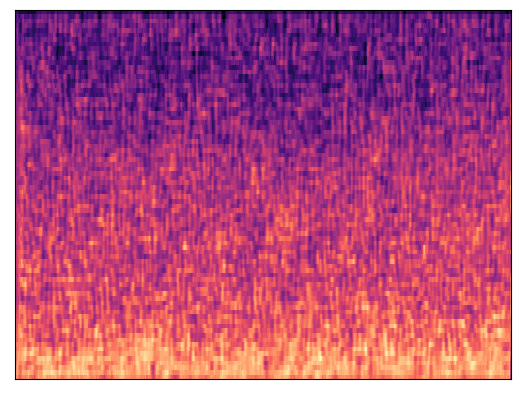

In [34]:
with torch.no_grad():
    quant_t = vqvae.vq_top.embed_code(top_sample)
    quant_t = quant_t.permute(0, 3, 1, 2).contiguous()
    
    quant_m = vqvae.vq_mid.embed_code(mid_sample)
    quant_m = quant_m.permute(0, 3, 1, 2).contiguous()
    
    quant_b = vqvae.vq_bot.embed_code(bot_sample)
    quant_b = quant_b.permute(0, 3, 1, 2).contiguous()

    
    out = vqvae.decode(quant_t, quant_m, quant_b).squeeze().detach().cpu().numpy() - 80.0
    librosa.display.specshow(out, sr=22050, hop_length=256)

In [22]:
out = librosa.db_to_power(out, ref=80)
y = librosa.feature.inverse.mel_to_audio(out, sr=22050, n_fft=2048, hop_length=256)
soundfile.write("sample/sampled_audio.wav", y, 22050, format='WAV')

In [23]:
torch.rand([1, 1, 1]).dtype

torch.float32